In [1]:
import requests
import json
import pandas as pd
import numpy as np

!pip install quandl
import quandl

# S&P500 Data

In [2]:
#S&P500 Data Call
'''
url = "https://alpha-vantage.p.rapidapi.com/query"

querystring = {"function":"TIME_SERIES_DAILY","symbol":"SPY","outputsize":"full","datatype":"json"}
# swap out compact for full to get 20 year history

headers = {
    'x-rapidapi-key': "85073711famsh14c401fb1c62dc5p138f19jsnd902d78d96ca",
    'x-rapidapi-host': "alpha-vantage.p.rapidapi.com"
    }

results = requests.request("GET", url, headers=headers, params=querystring)

#print(results.text)
'''

'\nurl = "https://alpha-vantage.p.rapidapi.com/query"\n\nquerystring = {"function":"TIME_SERIES_DAILY","symbol":"SPY","outputsize":"full","datatype":"json"}\n# swap out compact for full to get 20 year history\n\nheaders = {\n    \'x-rapidapi-key\': "85073711famsh14c401fb1c62dc5p138f19jsnd902d78d96ca",\n    \'x-rapidapi-host\': "alpha-vantage.p.rapidapi.com"\n    }\n\nresults = requests.request("GET", url, headers=headers, params=querystring)\n\n#print(results.text)\n'

In [3]:
# S&P 500 Data

sp500 = pd.read_csv('/content/SP500_19500103_20201123.csv')

# Note: It looks like the fed announcments are usually at 5pm, with meeting notes coming out at 2pm.  Going to need to assume that impact isn't until the next day but the dates in the file are assuming 5pm.

#sp500=pd.DataFrame()
#sp500 = pd.DataFrame.from_dict(results.json()["Time Series (Daily)"])


sp500 = sp500.set_index('Date')
sp500.columns = ['symbol', 'open', 'high', 'low', 'close', 'volume']




#sp500 = sp500.T


sp500 = sp500.sort_index()

# FED DAY
# Previous Days Close to Open to Close to next day open
sp500['day_before_close'] = sp500.close.shift(1).astype(float) # Day Before
sp500['open'] = sp500['open'].astype(float)
sp500['close'] = sp500['close'].astype(float)
sp500['day_after_open'] = sp500.open.shift(-1).astype(float) # Day After Open
sp500['day_after_close'] = sp500.close.shift(-1).astype(float) # Day After Open
sp500['two_day_after_close'] = sp500.close.shift(-2).astype(float) # Day After Open
sp500['three_day_after_close'] = sp500.close.shift(-3).astype(float) # Day After Open
#sp500['four_day_after_close'] = sp500.close.shift(-4).astype(float) # Day After Open
#sp500['five_day_after_close'] = sp500.close.shift(-5).astype(float) # Day After Open



# Creating an avg
sp500['fed_announce_avg'] = (sp500['day_before_close'] + sp500['open'] + sp500['close'] + sp500['day_after_open'] + sp500['day_after_close'] + sp500['two_day_after_close'] )/6

sp500['day_after_close'] = sp500.close.shift(-1).astype(float) # Day After Open
sp500['fed_announce_pct_change'] = (sp500['three_day_after_close'] - sp500['fed_announce_avg']) / sp500['three_day_after_close']*100


# T-4 to T-2
# T-2 Close + T-3 Close + T-3 Close
sp500['two_day_before_close'] = sp500.close.shift(2).astype(float) # 2 Days Before
sp500['three_day_before_close'] = sp500.close.shift(3).astype(float) # 3 Days Before
sp500['four_day_before_close'] = sp500.close.shift(4).astype(float) # 4 Days Before
sp500['prev_close_avg'] = (sp500['two_day_before_close'] + sp500['three_day_before_close'] + sp500['four_day_before_close'])/3

sp500['day_before_pct_change'] = (sp500['day_before_close'] - sp500['prev_close_avg']) / sp500['day_before_close']*100

#####################################
# LOOKING AT OUR DATA
#####################################
sp500.head(10)

,symbol,open,high,low,close,volume,day_before_close,day_after_open,day_after_close,two_day_after_close,three_day_after_close,fed_announce_avg,fed_announce_pct_change,two_day_before_close,three_day_before_close,four_day_before_close,prev_close_avg,day_before_pct_change
Date,,,,,,,,,,,,,,,,,,
01-Apr-1952,SP500,24.18,24.18,24.18,24.18,1720000,NaN,25.25,25.25,27.17,36.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01-Apr-1953,SP500,25.25,25.25,25.25,25.25,2240000,24.18,27.17,27.17,36.95,44.14,27.661667,37.331974,NaN,NaN,NaN,NaN,NaN
01-Apr-1954,SP500,27.17,27.17,27.17,27.17,2270000,25.25,36.95,36.95,44.14,41.93,32.938333,21.444471,24.18,NaN,NaN,NaN,NaN
01-Apr-1955,SP500,36.95,36.95,36.95,36.95,2660000,27.17,44.14,44.14,41.93,55.69,38.546667,30.783504,25.25,24.18,NaN,NaN,NaN
01-Apr-1957,SP500,44.14,44.14,44.14,44.14,1620000,36.95,41.93,41.93,55.69,55.43,44.130000,20.386073,27.17,25.25,24.18,25.533333,30.897609
01-Apr-1958,SP500,41.93,41.93,41.93,41.93,2070000,44.14,55.69,55.69,55.43,66.85,49.135000,26.499626,36.95,27.17,25.25,29.790000,32.510195
01-Apr-1959,SP500,55.69,55.69,55.69,55.69,2980000,41.93,55.43,55.43,66.85,79.24,55.170000,30.376073,44.14,36.95,27.17,36.086667,13.935925
01-Apr-1960,SP500,55.43,55.43,55.43,55.43,2260000,55.69,66.57,66.85,79.24,86.32,63.201667,26.782129,41.93,44.14,36.95,41.006667,26.366194
01-Apr-1963,SP500,66.57,67.18,66.23,66.85,3890000,55.43,78.98,79.24,86.32,89.94,72.231667,19.689052,55.69,41.93,44.14,47.253333,14.751338


# FED Data

In [4]:
# Pulling the Fed_Rate
# Fed rate changes day after announcment

fed_rate = quandl.get("FRED/DFF", authtoken="NPExo1wnSkPZTDxv2bCR")

fed_rate = fed_rate.sort_index()

fed_rate['Next_Rate'] = fed_rate.Value.shift(-1).astype(float)
fed_rate['Value'] = fed_rate['Value'].astype(float)

fed_rate['pct_change_in_fed_rate'] = (fed_rate['Next_Rate'] - fed_rate['Value']) / fed_rate['Next_Rate']*100

fed_rate.head(10)

fed_rate.to_csv('new_fed_rate.csv')



# US Treasuries

In [5]:
# Pulling US Treasuries
'''
ten_year = quandl.get("USTREASURY/REALYIELD", authtoken="NPExo1wnSkPZTDxv2bCR")
ten_year.columns = ['five_yr', 'seven_yr', 'ten_yr', 'twenty_yr', 'thirty_yr']

ten_year = ten_year.sort_index()
ten_year['ten_yr'] = ten_year['ten_yr'].astype(float)

ten_year['one_day_before'] = ten_year.ten_yr.shift(1).astype(float) # 1 Days Before
ten_year['two_day_before'] = ten_year.ten_yr.shift(2).astype(float) # 2 Days Before
ten_year['three_day_before'] = ten_year.ten_yr.shift(3).astype(float) # 3 Days Before

ten_year['prev_days_avg'] = (ten_year['one_day_before'] + ten_year['two_day_before'] + ten_year['three_day_before'])/3


ten_year['day_before_pct_change'] = (ten_year['ten_yr'] - ten_year['prev_days_avg']) / ten_year['ten_yr']*100

ten_year.tail(10)
'''

ten_year = pd.read_csv('DGS10v2.csv')  

ten_year = ten_year.set_index('DATE')

ten_year.columns = ['ten_yr']

ten_year = ten_year.sort_index()

#ten_year['ten_yr'] = float(ten_year['ten_yr'])
ten_year['ten_yr'].apply(lambda x: float(x))


ten_year['one_day_before'] = ten_year.ten_yr.shift(1).astype(float) # 1 Days Before
ten_year['two_day_before'] = ten_year.ten_yr.shift(2).astype(float) # 2 Days Before
ten_year['three_day_before'] = ten_year.ten_yr.shift(3).astype(float) # 3 Days Before

ten_year['prev_days_avg'] = (ten_year['one_day_before'] + ten_year['two_day_before'] + ten_year['three_day_before'])/3


ten_year['day_before_pct_change'] = (ten_year['ten_yr'] - ten_year['prev_days_avg']) / ten_year['ten_yr']*100

ten_year.head(10)

#ten_year.dtypes

,ten_yr,one_day_before,two_day_before,three_day_before,prev_days_avg,day_before_pct_change
DATE,,,,,,
1/10/1962,4.07,NaN,NaN,NaN,NaN,NaN
1/10/1963,3.81,4.07,NaN,NaN,NaN,NaN
1/10/1964,4.18,3.81,4.07,NaN,NaN,NaN
1/10/1966,4.61,4.18,3.81,4.07,4.020000,12.798265
1/10/1967,4.69,4.61,4.18,3.81,4.200000,10.447761
1/10/1968,5.46,4.69,4.61,4.18,4.493333,17.704518
1/10/1969,6.03,5.46,4.69,4.61,4.920000,18.407960
1/10/1972,5.86,6.03,5.46,4.69,5.393333,7.963595
1/10/1973,6.43,5.86,6.03,5.46,5.783333,10.057024


In [40]:
sp500_and_fed_rate = pd.merge(sp500, fed_rate, left_index=True, right_index=True)

#sp500_and_fed_rate.to_csv('SP500AndFed.csv')
sp500_and_fed_rate_and_ten_year = pd.merge(sp500_and_fed_rate, ten_year, left_index=True, right_index=True)
sp500_and_fed_rate_and_ten_year = sp500_and_fed_rate_and_ten_year.loc[sp500_and_fed_rate_and_ten_year.index > '1992-12-31']

#combined_graph = sp500_and_fed_rate_and_ten_year.reset_index()
#combined_graph['Date_graph'] = pd.to_datetime(combined_graph['index'], format='%Y%m%d', errors='ignore')

#combined_graph.head()

combined_graph = combined_graph.loc[(combined['Date']>'1992-12-31')]


combined = sp500_and_fed_rate_and_ten_year.reset_index()

combined.columns = ['Date', 'symbol', 'open', 'high', 'low', 'close', 'volume', 'day_before_close', 'day_after_open', 'day_after_close', 'two_day_after_close', 'three_day_after_close', 'fed_announce_avg', 'fed_announce_pct_change', 'two_day_before_close', 'three_day_before_close', 'four_day_before_close', 'prev_close_avg', 'pct_change_sp500', 'fed_rate', 'prev_fed_rate', 'pct_change_in_fed_rate', '10_yr', 'one_day_before_10', 'two_day_before_10', 'three_day_before_10', 'prev_days_avg_treas', 'pct_change_in_treas']

combined['Date'] = pd.to_datetime(combined['Date'], format='%Y%m%d', errors='ignore')


combined.head(20)
#combined_graph.head()

,Date,symbol,open,high,low,close,volume,day_before_close,day_after_open,day_after_close,two_day_after_close,three_day_after_close,fed_announce_avg,fed_announce_pct_change,two_day_before_close,three_day_before_close,four_day_before_close,prev_close_avg,pct_change_sp500,fed_rate,prev_fed_rate,pct_change_in_fed_rate,10_yr,one_day_before_10,two_day_before_10,three_day_before_10,prev_days_avg_treas,pct_change_in_treas
0,1993-01-04,SP500,435.70,437.32,434.48,435.38,201210000,321.00,465.44,466.89,460.71,617.70,430.853333,30.248772,355.67,279.43,255.94,297.013333,7.472482,3.60,3.33,-8.108108,6.60,8.02,7.98,9.22,8.406667,-27.373737
1,1993-01-05,SP500,435.38,435.40,433.55,434.34,240350000,352.20,466.89,467.55,460.34,616.71,436.116667,29.283348,280.01,258.63,252.19,263.610000,25.153322,3.33,3.62,8.011050,6.61,7.99,9.27,8.76,8.673333,-31.215330
2,1993-01-06,SP500,434.34,435.17,432.52,434.52,295240000,417.96,467.55,467.12,460.68,747.65,447.028333,40.208877,280.67,258.89,252.78,264.113333,36.808945,3.62,3.25,-11.384615,6.63,6.82,9.25,8.82,8.296667,-25.138260
3,1993-01-07,SP500,434.52,435.46,429.76,430.73,304850000,417.40,467.09,469.90,753.23,964.00,495.478333,48.601833,315.44,261.07,255.33,277.280000,33.569717,3.25,2.93,-10.921502,6.76,6.76,8.13,8.83,7.906667,-16.962525
4,1993-01-08,SP500,430.73,430.73,426.88,429.05,263470000,418.10,616.71,618.46,748.41,956.05,543.576667,43.143490,314.90,353.79,243.40,304.030000,27.282947,2.93,2.93,0.000000,6.75,6.77,8.16,8.02,7.650000,-13.333333
5,1993-01-11,SP500,429.04,431.04,429.01,430.95,217150000,315.23,475.27,474.13,461.66,602.69,431.046667,28.479539,348.53,282.01,247.49,292.676667,7.154564,3.06,2.91,-5.154639,6.71,8.20,8.04,9.24,8.493333,-26.577248
6,1993-01-12,SP500,430.95,431.39,428.19,431.04,239410000,339.93,474.13,474.17,461.64,601.81,435.310000,27.666539,283.17,245.42,260.30,262.963333,22.641916,2.91,2.87,-1.393728,6.72,8.10,9.14,8.93,8.723333,-29.811508
7,1993-01-13,SP500,431.03,433.44,429.99,433.03,245360000,414.34,474.17,472.47,465.97,759.51,448.501667,40.948550,283.87,245.81,259.95,263.210000,36.474876,2.87,2.97,3.367003,6.71,6.92,9.06,8.87,8.283333,-23.447591
8,1993-01-14,SP500,433.08,435.96,433.08,435.94,281040000,420.44,472.50,474.91,768.86,957.94,500.955000,47.704971,312.49,245.88,262.64,273.670000,34.908667,2.97,2.96,-0.337838,6.65,7.03,8.23,8.86,8.040000,-20.902256
9,1993-01-15,SP500,435.87,439.49,435.84,437.15,309720000,420.77,601.81,599.82,767.20,950.73,543.770000,42.805002,313.73,337.00,252.05,300.926667,28.481910,2.96,2.96,0.000000,6.60,7.05,8.22,8.60,7.956667,-20.555556


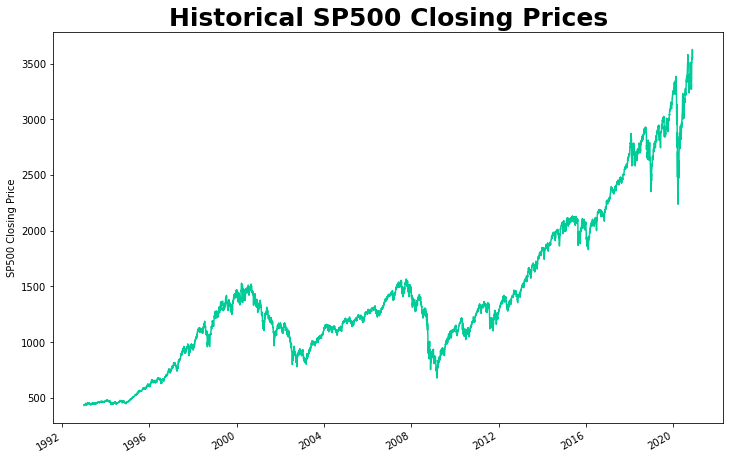

In [42]:
import matplotlib.pyplot as plt

sp500_and_fed_rate_and_ten_year['close'].plot(figsize=(12, 8), color='#00cc99')

#plt.xlabel('Date')
plt.title('Historical SP500 Closing Prices', fontweight='bold', fontsize = 25)
plt.ylabel('SP500 Closing Price')

plt.show()

In [8]:
combined.dtypes

Date                       datetime64[ns]
symbol                             object
open                              float64
high                              float64
low                               float64
close                             float64
volume                              int64
day_before_close                  float64
day_after_open                    float64
day_after_close                   float64
two_day_after_close               float64
three_day_after_close             float64
fed_announce_avg                  float64
fed_announce_pct_change           float64
two_day_before_close              float64
three_day_before_close            float64
four_day_before_close             float64
prev_close_avg                    float64
pct_change_sp500                  float64
fed_rate                          float64
prev_fed_rate                     float64
pct_change_in_fed_rate            float64
10_yr                             float64
one_day_before_10                 

In [9]:
# Pulling in Fed dates

df_dates = pd.read_csv('FOMC_meeting_dates_label_v3.csv')
df_dates['Date'] = pd.to_datetime(df_dates['MeetingDate'], format='%Y%m%d', errors='ignore')

df_dates = df_dates.set_index('Date')

df_dates.head(20)

,MeetingDate,PressConference,IsNew,MeetingType
Date,,,,
1993-02-03,19930203,0,Yes,Meeting Date
1993-03-23,19930323,0,Yes,Meeting Date
1993-05-18,19930518,0,Yes,Meeting Date
1993-07-07,19930707,0,Yes,Meeting Date
1993-08-17,19930817,0,Yes,Meeting Date
1993-09-21,19930921,0,Yes,Meeting Date
1993-11-16,19931116,0,Yes,Meeting Date
1993-12-21,19931221,0,Yes,Meeting Date
1994-02-04,19940204,0,Yes,Meeting Date


In [10]:
df_dates.dtypes

MeetingDate         int64
PressConference     int64
IsNew              object
MeetingType        object
dtype: object

In [11]:
df_final =  pd.merge(df_dates, combined, left_on = 'Date', right_on='Date')
#df_final.sort_values('Date')

In [12]:
df_final.dtypes

Date                       datetime64[ns]
MeetingDate                         int64
PressConference                     int64
IsNew                              object
MeetingType                        object
symbol                             object
open                              float64
high                              float64
low                               float64
close                             float64
volume                              int64
day_before_close                  float64
day_after_open                    float64
day_after_close                   float64
two_day_after_close               float64
three_day_after_close             float64
fed_announce_avg                  float64
fed_announce_pct_change           float64
two_day_before_close              float64
three_day_before_close            float64
four_day_before_close             float64
prev_close_avg                    float64
pct_change_sp500                  float64
fed_rate                          

In [13]:
#df_final.to_csv('quick_check.csv')

# Constructing the Label

In [14]:
#SP500

# If the Fed Announce Pct Change (the S&P500 around the FED) is greater than the days leading up to the announce (pct_change_SP500) then this is positive.
# Otherwise this is negative

# FED Rate

# If the FED pct change is positive then this is positive (economy is doing better, FED wants to avoid inflation)
# If the FED pct change is 0 then this is neutral 
# If the FED pct change is negative then this is negative (FED wants to stimulate growth)

# Treasury

# If the 10 year treasury rate % change is postiive, then this is positive
# If the 10 year treasury rate % change is negative, then this is negative

# Fields for comparison
# fed_announce_pct_change
# pct_change_sp500
# pct_change_in_fed_rate
# pct_change_in_treas
'''
# create a list of our conditions
conditions = [
    # S&P500 is positive

    # Positive, Negative, Positive = 1 - 1 + 1 = 1
    ( (df_final['fed_announce_pct_change'] >= df_final['pct_change_sp500']) & (df_final['pct_change_in_fed_rate'] < 0) & (df_final['pct_change_in_treas'] >= 0) ),

    # Positive, Negative, Negative = 1 - 1 - 1 = -1
    ((df_final['fed_announce_pct_change'] >= df_final['pct_change_sp500']) & (df_final['pct_change_in_fed_rate'] < 0) & (df_final['pct_change_in_treas'] < 0)),

    # Positive, Neutral, #Positive = 1 + 0 + 1 = 2
    ((df_final['fed_announce_pct_change'] >= df_final['pct_change_sp500']) & (df_final['pct_change_in_fed_rate'] == 0) & (df_final['pct_change_in_treas'] >= 0)),

    # Positive, Neutral, #Negative = 1 + 0 - 1 = 0
    ((df_final['fed_announce_pct_change'] >= df_final['pct_change_sp500']) & (df_final['pct_change_in_fed_rate'] == 0) & (df_final['pct_change_in_treas'] < 0)),

    # Positive, Positve, #Positive = 1 + 1 + 1 = 3
    ((df_final['fed_announce_pct_change'] >= df_final['pct_change_sp500']) & (df_final['pct_change_in_fed_rate'] > 0) & (df_final['pct_change_in_treas'] >= 0)),

    # Positive, Positive, #Negative = 1 + 1 - 1 = 2
    ((df_final['fed_announce_pct_change'] >= df_final['pct_change_sp500']) & (df_final['pct_change_in_fed_rate'] > 0) & (df_final['pct_change_in_treas'] < 0)),

    #S&P 500 is negative

    # Negatve, Negative, Positive = -1 - 1 + 1 = -1
    ((df_final['fed_announce_pct_change'] < df_final['pct_change_sp500']) & (df_final['pct_change_in_fed_rate'] < 0) & (df_final['pct_change_in_treas'] >= 0)),

    # Negatve, Negative, Negative = -1 - 1 - 1 = -3
    ((df_final['fed_announce_pct_change'] < df_final['pct_change_sp500']) & (df_final['pct_change_in_fed_rate'] < 0) & (df_final['pct_change_in_treas'] < 0)),

    # Negatve, Neutral, #Positive = -1 + 0 + 1 = 0
    ((df_final['fed_announce_pct_change'] < df_final['pct_change_sp500']) & (df_final['pct_change_in_fed_rate'] == 0) & (df_final['pct_change_in_treas'] >= 0)),

    # Negatve, Neutral, #Negative = -1 + 0 - 1 = -2
    ((df_final['fed_announce_pct_change'] < df_final['pct_change_sp500']) & (df_final['pct_change_in_fed_rate'] == 0) & (df_final['pct_change_in_treas'] < 0)),

    # Negatve, Positve, #Positive = -1 + 1 + 1 = 1
    ((df_final['fed_announce_pct_change'] < df_final['pct_change_sp500']) & (df_final['pct_change_in_fed_rate'] > 0) & (df_final['pct_change_in_treas'] >= 0)),

    # Negatve, Positive, #Negative = -1 + 1 - 1 = -1
    ((df_final['fed_announce_pct_change'] < df_final['pct_change_sp500']) & (df_final['pct_change_in_fed_rate'] > 0) & (df_final['pct_change_in_treas'] < 0))
    ]



# create a list of the values we want to assign for each condition
#values = ['1', '-1', '2', '0', '3', '2', '-1', '-3', '0', '-2', '1', '-1']

values = ['0', '0', '1', '0', '1', '1', '0', '-1', '0', '-1', '0', '0']

'''

conditions = [
    # S&P500 is positive

    # Positive, Positive = 1 + 1 = 2
    ( (df_final['fed_announce_pct_change'] >= df_final['pct_change_sp500']) &  (df_final['pct_change_in_treas'] >= 0) ),

    # Positive, Negative = 1 - 1 = 0
    ( (df_final['fed_announce_pct_change'] >= df_final['pct_change_sp500']) &  (df_final['pct_change_in_treas'] < 0) ),

  # S&P500 is negative

      # Negative, Positive = -1 + 1 = 0
    ( (df_final['fed_announce_pct_change'] < df_final['pct_change_sp500']) &  (df_final['pct_change_in_treas'] >= 0) ),

    # Negative, Negative = -1 - 1 = -2
    ( (df_final['fed_announce_pct_change'] < df_final['pct_change_sp500']) &  (df_final['pct_change_in_treas'] < 0) ),

]

values = ['1', '0', '0', '-1' ]


# create a new column and use np.select to assign values to it using our lists as arguments
df_final['label_market'] = np.select(conditions, values)


conditions_fed = [
    
    (df_final['pct_change_in_fed_rate'] > 0),

    (df_final['pct_change_in_fed_rate'] == 0),

    (df_final['pct_change_in_fed_rate'] < 0)

]

values_fed = ['1', '0', '-1' ]

  # S&P500 is negative

df_final['label_FED'] = np.select(conditions_fed, values_fed)


In [15]:
df_final

,Date,MeetingDate,PressConference,IsNew,MeetingType,symbol,open,high,low,close,volume,day_before_close,day_after_open,day_after_close,two_day_after_close,three_day_after_close,fed_announce_avg,fed_announce_pct_change,two_day_before_close,three_day_before_close,four_day_before_close,prev_close_avg,pct_change_sp500,fed_rate,prev_fed_rate,pct_change_in_fed_rate,10_yr,one_day_before_10,two_day_before_10,three_day_before_10,prev_days_avg_treas,pct_change_in_treas,label_market,label_FED
0,1993-02-03,19930203,0,Yes,Meeting Date,SP500,442.56,447.35,442.56,447.20,345410000,409.53,481.96,480.71,478.65,786.73,456.768333,41.940903,296.97,252.21,275.99,275.056667,32.836015,3.56,3.08,-15.584416,6.45,7.36,9.01,8.21,8.193333,-27.028424,0,-1
1,1993-03-23,19930323,0,Yes,Meeting Date,SP500,448.88,449.80,448.30,448.76,232730000,409.91,468.89,468.54,495.95,1095.55,456.821667,58.302070,337.22,288.98,268.91,298.370000,27.210851,2.93,2.92,-0.342466,5.91,7.62,8.52,9.43,8.523333,-44.218838,0,-1
2,1993-05-18,19930518,0,Yes,Meeting Date,SP500,440.39,441.26,437.95,440.32,264300000,412.81,449.39,453.69,519.58,1105.82,452.696667,59.062355,354.64,317.97,251.35,307.986667,25.392634,2.97,2.94,-1.020408,6.15,7.28,8.75,8.78,8.270000,-34.471545,0,-1
3,1993-07-07,19930707,0,Yes,Meeting Date,SP500,441.40,443.63,441.40,442.83,253170000,409.16,446.15,448.38,556.37,912.20,457.381667,49.859497,324.91,271.78,307.40,301.363333,26.345847,3.39,3.09,-9.708738,5.80,6.87,8.02,8.95,7.946667,-37.011494,0,-1
4,1993-08-17,19930817,0,Yes,Meeting Date,SP500,452.38,453.70,451.96,453.13,261320000,420.74,465.11,465.17,559.04,1083.67,469.261667,56.696996,327.83,344.45,260.77,311.016667,26.078655,3.10,3.02,-2.649007,5.70,6.56,8.80,8.18,7.846667,-37.660819,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,2020-04-08,20200408,1,No,Minute Date,SP500,2685.00,2760.75,2663.30,2749.98,3343868000,2895.77,18.46,18.46,22.93,25.55,1398.433333,-5373.320287,2047.60,2081.90,1851.96,1993.820000,31.147156,0.05,0.05,0.000000,0.77,2.52,1.72,1.92,2.053333,-166.666667,-1,0
439,2020-05-20,20200520,1,No,Minute Date,SP500,2953.63,2980.29,2953.63,2971.61,2849677000,2840.23,19.93,19.93,22.68,25.28,1471.335000,-5720.154272,2052.32,2125.85,1872.83,2017.000000,28.984624,0.05,0.05,0.000000,0.68,2.41,1.85,2.26,2.173333,-219.607843,-1,0
440,2020-07-01,20200701,1,No,Minute Date,SP500,3105.92,3128.44,3101.17,3115.86,2697727000,2964.33,18.77,18.77,21.48,24.15,1540.855000,-6280.351967,2102.95,2077.42,1973.32,2051.230000,30.802913,0.08,0.09,11.111111,0.69,2.03,1.46,2.43,1.973333,-185.990338,-1,1
441,2020-08-19,20200819,1,No,Minute Date,SP500,3392.51,3399.54,3369.66,3374.85,2018140000,2923.65,19.96,19.96,23.57,26.15,1625.750000,-6117.017208,2183.87,2079.61,1981.60,2081.693333,28.798135,0.09,0.09,0.000000,0.68,1.60,1.58,2.12,1.766667,-159.803922,-1,0


In [16]:
df_final.groupby(['label_market']).count()

,Date,MeetingDate,PressConference,IsNew,MeetingType,symbol,open,high,low,close,volume,day_before_close,day_after_open,day_after_close,two_day_after_close,three_day_after_close,fed_announce_avg,fed_announce_pct_change,two_day_before_close,three_day_before_close,four_day_before_close,prev_close_avg,pct_change_sp500,fed_rate,prev_fed_rate,pct_change_in_fed_rate,10_yr,one_day_before_10,two_day_before_10,three_day_before_10,prev_days_avg_treas,pct_change_in_treas,label_FED
label_market,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158
0,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261
1,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24


In [17]:
df_for_chart = df_final.groupby(['MeetingType', 'label_market']).count().reset_index()
df_for_chart_meeting_date = df_for_chart[df_for_chart['MeetingType']=='Meeting Date']
df_for_chart_minute_date = df_for_chart[df_for_chart['MeetingType']=='Minute Date']

In [18]:


df_final.to_csv('label_data_v2.csv')

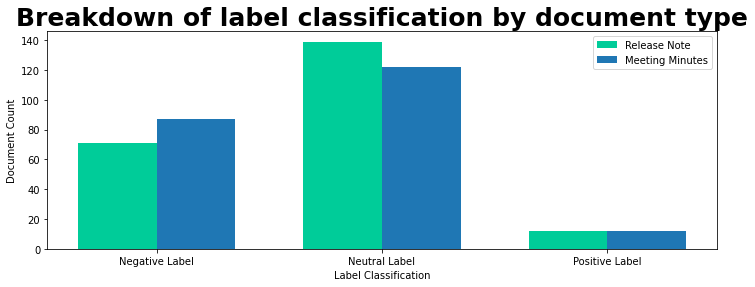

In [19]:
plt.figure(figsize=(12, 4))


N = 3


ind = np.arange(N) 
width = 0.35  

plt.bar(ind, df_for_chart_meeting_date['Date'], width, label='Release Note', color='#00cc99')
plt.bar(ind + width, df_for_chart_minute_date['Date'], width,
    label='Meeting Minutes')



plt.xlabel("Label Classification")
plt.ylabel("Document Count")
plt.title("Breakdown of label classification by document type", fontweight='bold', fontsize=25)

plt.xticks(ind + width / 2, ('Negative Label', 'Neutral Label', 'Positive Label'))
plt.legend(loc='best')

plt.show()